In [78]:
import os
import sys
import time
import random
import warnings

import cv2 as cv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [79]:
def acc_comp(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    mean_acc = np.zeros(1)

    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        acc2 = float(TP+TN)/(TP+TN+FP+FN)
        mean_acc = np.append([mean_acc],acc)
    
    mean_acc = mean_acc[1:]
    avg = round(mean_acc.sum()/msk.shape[0],6)
    std = round(np.std(mean_acc),6)
    
    return (avg,std)

In [80]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()   

In [81]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [82]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 5: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Combine everything
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4))
train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4))
mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4))

In [83]:
# Get and resize train images and masks DONT RUN IN THIS CODE
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH[n] + id_
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 2379/2379 [00:06<00:00, 277.68it/s]


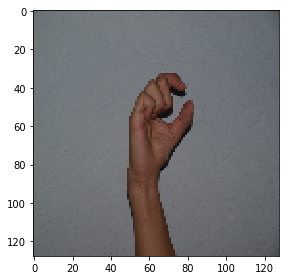

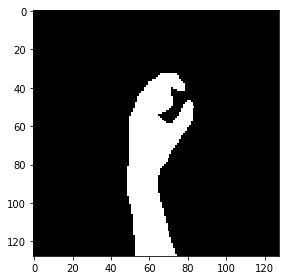

In [84]:
# Check if training masks match ground truth
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

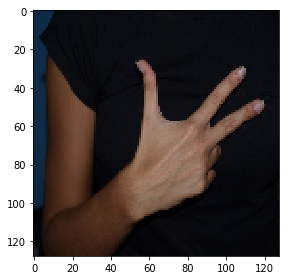

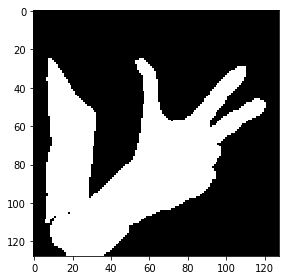

In [85]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [86]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [88]:
# Fit model
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-3Feb2019-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=16, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

Train on 1665 samples, validate on 714 samples
Epoch 1/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.1526 - acc: 0.9412 - val_loss: 0.1924 - val_acc: 0.9361

Epoch 00001: val_loss improved from inf to 0.19241, saving model to model-3Feb2019-1.h5
Epoch 2/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.1233 - acc: 0.9531 - val_loss: 0.1870 - val_acc: 0.9336

Epoch 00002: val_loss improved from 0.19241 to 0.18703, saving model to model-3Feb2019-1.h5
Epoch 3/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.1101 - acc: 0.9592 - val_loss: 0.1717 - val_acc: 0.9390

Epoch 00003: val_loss improved from 0.18703 to 0.17169, saving model to model-3Feb2019-1.h5
Epoch 4/50
1665/1665 [==============================] - 79s 48ms/step - loss: 0.0955 - acc: 0.9649 - val_loss: 0.1813 - val_acc: 0.9435

Epoch 00004: val_loss did not improve from 0.17169
Epoch 5/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.08

1665/1665 [==============================] - 80s 48ms/step - loss: 0.0348 - acc: 0.9870 - val_loss: 0.1248 - val_acc: 0.9649

Epoch 00042: val_loss did not improve from 0.11169
Epoch 43/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.0341 - acc: 0.9873 - val_loss: 0.1206 - val_acc: 0.9655

Epoch 00043: val_loss did not improve from 0.11169
Epoch 44/50
1665/1665 [==============================] - 81s 48ms/step - loss: 0.0335 - acc: 0.9874 - val_loss: 0.1252 - val_acc: 0.9659

Epoch 00044: val_loss did not improve from 0.11169
Epoch 45/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.0330 - acc: 0.9876 - val_loss: 0.1260 - val_acc: 0.9656

Epoch 00045: val_loss did not improve from 0.11169
Epoch 46/50
1665/1665 [==============================] - 80s 48ms/step - loss: 0.0325 - acc: 0.9878 - val_loss: 0.1308 - val_acc: 0.9625

Epoch 00046: val_loss did not improve from 0.11169
Epoch 47/50
1665/1665 [==============================] - 80s 48ms/s

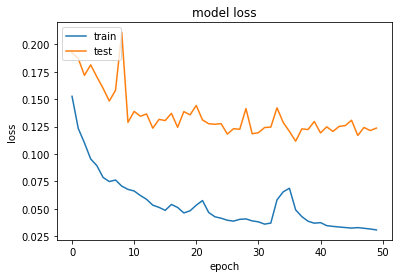

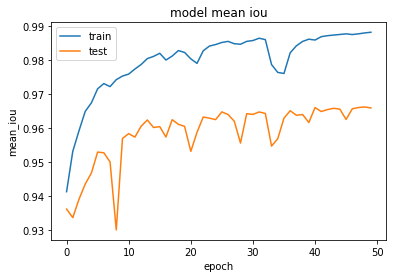

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 2379
Max num of epochs: 50
Optimizer: ADAM
Batch size: 16
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   81.273300   0.941200    0.152600    0.936100    0.192408
1   80.013500   0.953100    0.123300    0.933600    0.187026
2   80.171700   0.959200    0.110100    0.939000    0.171689
3   79.436900   0.964900    0.095500    0.943500    0.181303
4   79.915000   0.967500    0.089400    0.946800    0.170255
5   80.048400   0.971600    0.078600    0.952900    0.159893
6   80.008000   0.973100    0.074900    0.952700    0.148286
7   79.567400   0.972200    0.076300    0.950000    0.158055
8   79.746300   0.974300    0.070800    0.930000    0.210979
9   80.00

In [89]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model mean iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 16)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [91]:
# Predict on train and validation tests
model = load_model('model-3Feb2019-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

238/238 [==============================] - 3s 11ms/step


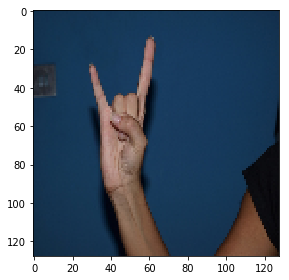

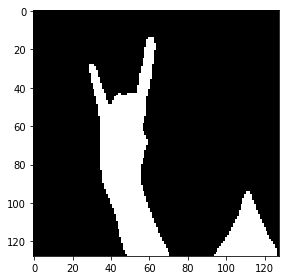

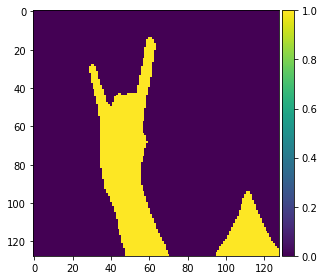

In [12]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

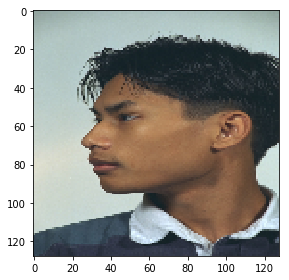

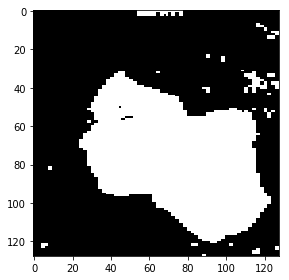

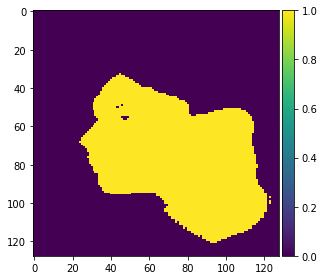

In [93]:
# Sanity check on random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [94]:
# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/testing_data/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/ground_truth/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_id = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_id.sort()
msk_ids = msk_id[1:]

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    img = (img > 15).astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
acc_comp(msk, preds_test_t)

100%|██████████| 49/49 [00:00<00:00, 137.35it/s]


50/50 [==============================] - 1s 10ms/step


(0.553417, 0.12432)

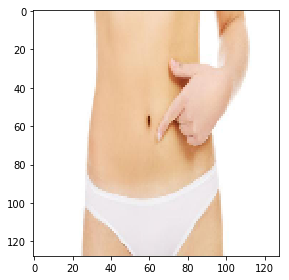

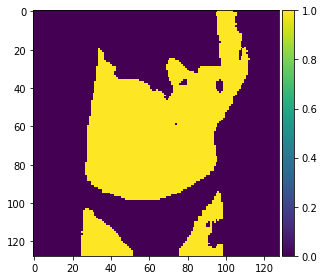

In [102]:
# Visualize Predictions
ix = random.randint(0, len(abd_ids)-1)
imshow(abd[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()